In [29]:
import numpy as np
import json
import csv
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
from sklearn import svm
import xgboost as xgb
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

from sklearn.ensemble import VotingRegressor, VotingClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
%matplotlib inline

In [30]:
def load_data():
    data = pd.read_pickle('../../data/dataframes/data.pkl')
    nomination_onehot = pd.read_pickle('../../data/dataframes/nomination_onehot.pkl')
    selected_performers_onehot = pd.read_pickle('../../data/dataframes/selected_performers_onehot.pkl')
    selected_directors_onehot = pd.read_pickle('../../data/dataframes/selected_directors_onehot.pkl')
    selected_studio_onehot = pd.read_pickle('../../data/dataframes/selected_studio_onehot.pkl')
    selected_scriptwriter_onehot = pd.read_pickle('../../data/dataframes/selected_scriptwriter_onehot.pkl')
    review_dataframe = pd.read_pickle('../../data/dataframes/review_dataframe.pkl')
#     tf_idf = pd.read_pickle('../../data/dataframes/tfidf.pkl')
#     lda_topics = pd.read_pickle('../eigacom_review/topics.pkl')

    
    # selected_directors_onehotとselected_scriptwriter_onehotの重複した人
    duplicate_scriptwriter = set(selected_directors_onehot.columns) & set(selected_scriptwriter_onehot.columns)
    selected_scriptwriter_onehot = selected_scriptwriter_onehot.drop(duplicate_scriptwriter, axis=1)
    
    frames = [nomination_onehot,selected_performers_onehot,selected_directors_onehot,selected_studio_onehot,selected_scriptwriter_onehot,]

    df = data
    for f in frames:
        df = pd.merge(df, f, on='id')
    
    drop_elements = ["director", "other_nominates", "performers", "production_studio", "scriptwriter", "title",  'selected_performers', 'selected_directors', 'selected_studio',
       'selected_scriptwriter']
    df_drop = df.drop(drop_elements, axis=1)

    return df_drop, data

In [31]:
def standard(x_train, x_test):
    stdsc = StandardScaler()

    # 訓練用のデータを標準化
    x_train_std = stdsc.fit_transform(x_train)
    # 訓練用データを基準にテストデータも標準化
    x_test_std = stdsc.transform(x_test)
    
    return x_train_std, x_test_std

In [32]:
# 多重共線性の排除 (共分散0.7以上のfeatureを削除)

def collinearity(X):

    # 改善前
#     cor=np.corrcoef(X.T)
#     type(cor)
#     plt.figure(figsize=(20, 20))
#     sns.heatmap(cor, vmin=0.70,vmax=1,cmap=plt.cm.Spectral_r)

    # 改善
    drop_clm = ['吉田一夫']
    X = X.drop(drop_clm,  axis=1)

    # 改善後
    
#     cor=np.corrcoef(X.T)
#     type(cor)
#     plt.figure(figsize=(20, 20))
#     sns.heatmap(cor, vmin=0.80,vmax=1,cmap=plt.cm.Spectral_r)
    
    return X

In [33]:
def data_processing(test_year):
    df, data = load_data()
    
    df = collinearity(df)
    
    train = df.loc[df["year"] != test_year]
    test = df.loc[df["year"] == test_year]
    
    # 入力データの作成
    y_train = train['prize'].ravel()
    x_train = train.drop(['prize', 'year'], axis=1)
    
    features = x_train.columns
    
    x_train = x_train.values # 学習データ
    
    # テストデータの作成
    y_test = test['prize'].ravel()
    x_test = test.drop(['prize', 'year'], axis=1)
    x_test = x_test.values # テストデータ

    # データの標準化
    x_train_std, x_test_std = standard(x_train, x_test)
    
    return x_train_std, x_test_std, y_train, y_test, features

In [34]:
def plot_roc_curve(fpr, tpr, auc):
    # ROC曲線をプロット
    plt.plot(fpr, tpr, label='ROC curve (area = %.2f)'%auc)
    plt.legend()
    plt.title('ROC curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid(True)
    plt.show()

In [35]:
def create_models():
    lr = LogisticRegression(class_weight="balanced", solver="liblinear",  penalty="l2", C=0.0001)
    
    sv = svm.SVR(kernel="poly",
                                 degree=8,
                                 gamma=0.03521735642853326,
                                 coef0=0.34010389238140537,
                                 tol=1e-05,
                                 C=0.001,
                                 epsilon=0.14620884632948022,
                                verbose=True,)

    xgboost = xgb.XGBRegressor(silent= True, 
                           max_depth=1,
                           learning_rate=0.14544434403253392,
                           n_estimators = 72,
                           gamma=0.4356018082020117,
                           reg_lambda=2.931451663505623,
                           reg_alpha=0.19045302677956732)

    lgbm = lgb.LGBMRegressor(
        verbosity=1,
        boost_from_average='true',
        metric='auc',
        bagging_freq=5,
        max_depth=19,
        learning_rate=0.09802221664336347,
        n_estimators=703,
        subsample=0.7596658467659505,
        reg_lambda=0.4087114877863393,  
    )
    
    lda = LDA(solver="eigen", shrinkage=1)

    estimators_rgs = [('sv', sv), ('lgbm', lgbm), ('xgboost', xgboost)]
    
    return estimators_rgs

In [36]:
def main():
    
#     df =  pd.read_pickle('../../data/dataframes/unificated_data_set.pkl')
    
    cm_all = np.zeros((2, 2))
    
    # 予測した確率全体を格納
    probs_all = np.array([])
    y_true_all = np.array([])
    
    for y in range(1978, 2020):
        
        # データの生成
        x_train_std, x_test_std, y_train, y_test, features = data_processing(y)
       
        # 学習
        estimators= create_models()
        
        vr = VotingRegressor(estimators)

        vr.fit(x_train_std, y_train)
        
        # 予測(確率)
        probs = vr.predict(x_test_std)
        probs_all = np.hstack((probs_all, probs))
        y_true_all = np.hstack((y_true_all, y_test))
        
        print(probs)

        # 混同行列
        y_pred = np.where((probs ==  max(probs)), 1, 0) #確率→0/1
        cm = confusion_matrix(y_true=y_test, y_pred=y_pred)
        cm_all += cm
    
    auc = roc_auc_score(y_true_all, probs_all)
    fpr, tpr, thresholds = roc_curve(y_true_all, probs_all)
    
    plot_roc_curve(fpr, tpr, auc)
    
    print("len: {0} , {1}".format(len(y_true_all), len(probs_all) ))
    print("confusion_matrix: ")
    print(cm_all)
    print("AUC: ")
    print(auc)
    print()
    return

[LibSVM][0.17402895 0.12052789 0.07159099 0.12072334 0.08602744]
[LibSVM][0.30883511 0.08532675 0.10056815 0.21667932 0.10899102]
[LibSVM][0.17744168 0.27996493 0.15055101 0.2296736  0.08220339]
[LibSVM][0.01827599 0.20441298 0.0912113  0.08498068 0.25390646]
[LibSVM][0.25631779 0.4223739  0.17041732 0.26691885 0.0889072 ]
[LibSVM][0.35454754 0.10091742 0.07739656 0.07295017 0.13697782]
[LibSVM][0.08290876 0.16487434 0.11615501 0.22983449 0.13043923]
[LibSVM][0.21444562 0.13592493 0.29335943 0.12867452 0.06262804]
[LibSVM][0.11996849 0.09393593 0.14966789 0.29909787 0.2504417 ]
[LibSVM][0.17332209 0.1210874  0.07603847 0.08361402 0.23367999]
[LibSVM][0.4426942  0.1201885  0.08135071 0.13309734 0.14407053]
[LibSVM][0.09120782 0.14185721 0.07545653 0.31215998 0.14155823]
[LibSVM][0.37430905 0.06948583 0.09965477 0.15135391 0.08664746]
[LibSVM][0.3819999  0.1629663  0.09906738 0.16363575 0.12828656]
[LibSVM][0.61110775 0.2293797  0.17345652 0.15071818 0.07664148]
[LibSVM][0.60094984 0.153

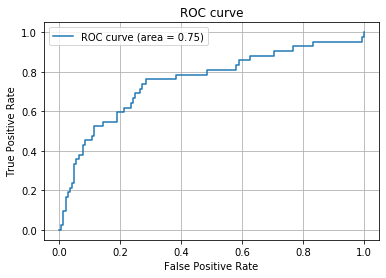

len: 211 , 211
confusion_matrix: 
[[149.  20.]
 [ 20.  22.]]
AUC: 
0.753592561284869



In [37]:
main()